In [1]:
# Use modules from parent directory
import os
import sys
import tifffile as tiff
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000   
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
from srcv2_2.models.params import get_params
from srcv2_2.models.Unet import Unet, UnetV2
from srcv2_2.visualization.make_image_files import visualize_test_data, __visualize_landsat8_tile__
from srcv2_2.visualization.visualization_utils import get_predicted_thumbnails 
from srcv2_2.utils import get_model_name

import tensorflow as tf

2024-03-12 15:23:13.639579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 15:23:13.657936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 15:23:13.657956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 15:23:13.658395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 15:23:13.661687: I tensorflow/core/platform/cpu_feature_guar

## Load KERAS Model

In [2]:
params = get_params('U-net', 'Landsat8')
params.cls = ['cloud', 'thin'] # clear, cloud, shadow, snow, water
params.project_path = "/home/mxh/RS-Net/"
activation_func='relu'
params.learning_rate =1e-3
params.epochs = 5
params.threshold = 0.5
params.dropout = 0
params.L2reg = 0
params.decay = 0
params.num_gpus = 1
params.modelID = "Test_Local"
params.norm_threshold = 3500

#tile = 'all'  # Name of one tile or 'all'
#tile = 'L2A_T32UNF_20170803T103019' 

In [3]:
local_loaded_model = tf.keras.saving.load_model(f"../models/Unet/{get_model_name(params)}.keras")
# weights and funcs will automatically be loaded

unet_loaded_local_model = UnetV2(params, model=local_loaded_model)

2024-03-12 15:23:16.386225: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-03-12 15:23:16.386242: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: mcom
2024-03-12 15:23:16.386245: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: mcom
2024-03-12 15:23:16.386325: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-03-12 15:23:16.386334: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-03-12 15:23:16.386336: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration


In [4]:
tf.keras.saving.get_custom_objects()

{'Custom>Adadelta': keras.src.optimizers.adadelta.Adadelta,
 'Custom>Adafactor': keras.src.optimizers.adafactor.Adafactor,
 'Custom>Adagrad': keras.src.optimizers.adagrad.Adagrad,
 'Custom>Adam': keras.src.optimizers.adam.Adam,
 'Custom>Adamax': keras.src.optimizers.adamax.Adamax,
 'Custom>AdamW': keras.src.optimizers.adamw.AdamW,
 'Custom>Ftrl': keras.src.optimizers.ftrl.Ftrl,
 'Custom>Lion': keras.src.optimizers.lion.Lion,
 'Custom>Nadam': keras.src.optimizers.nadam.Nadam,
 'Custom>RMSprop': keras.src.optimizers.rmsprop.RMSprop,
 'Custom>SGD': keras.src.optimizers.sgd.SGD,
 'Custom>CustomScaleLayer': keras.src.applications.inception_resnet_v2.CustomScaleLayer,
 'Custom>SharpnessAwareMinimization': keras.src.models.sharpness_aware_minimization.SharpnessAwareMinimization,
 'Custom>get_params': <function srcv2_2.models.params.get_params(model, satellite)>,
 'Custom>jaccard_coef': <function srcv2_2.models.model_utils.jaccard_coef(y_true, y_pred)>,
 'Custom>jaccard_coef_thresholded': <fun

In [5]:
from osgeo import gdal
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

In [6]:
day1 = "MOD09GA.A2023335.h18v04.061.2023340033530"
modis_tower_path="/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"

img_tiff_toa  = tiff.imread(modis_tower_path+day1+"_TOA_256.tiff")
img_gdal_toa = gdal.Open(modis_tower_path+day1+"_TOA_256.tiff").ReadAsArray()

img_gdal_merged = gdal.Open(modis_tower_path+day1+"_merged_256.tif")
img_tiff_merged  = tiff.imread(modis_tower_path+day1+"_merged_256.tif")

/home/mxh/anaconda3/envs/tf2+gpu/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [7]:
resized_img_tiff_toa = tf.image.resize(img_tiff_toa, (256,256))
resized_img_gdal_merged = tf.image.resize(img_gdal_merged.ReadAsArray(), (256,256))
resized_img_tiff_merged = tf.image.resize(img_tiff_merged, (256,256))

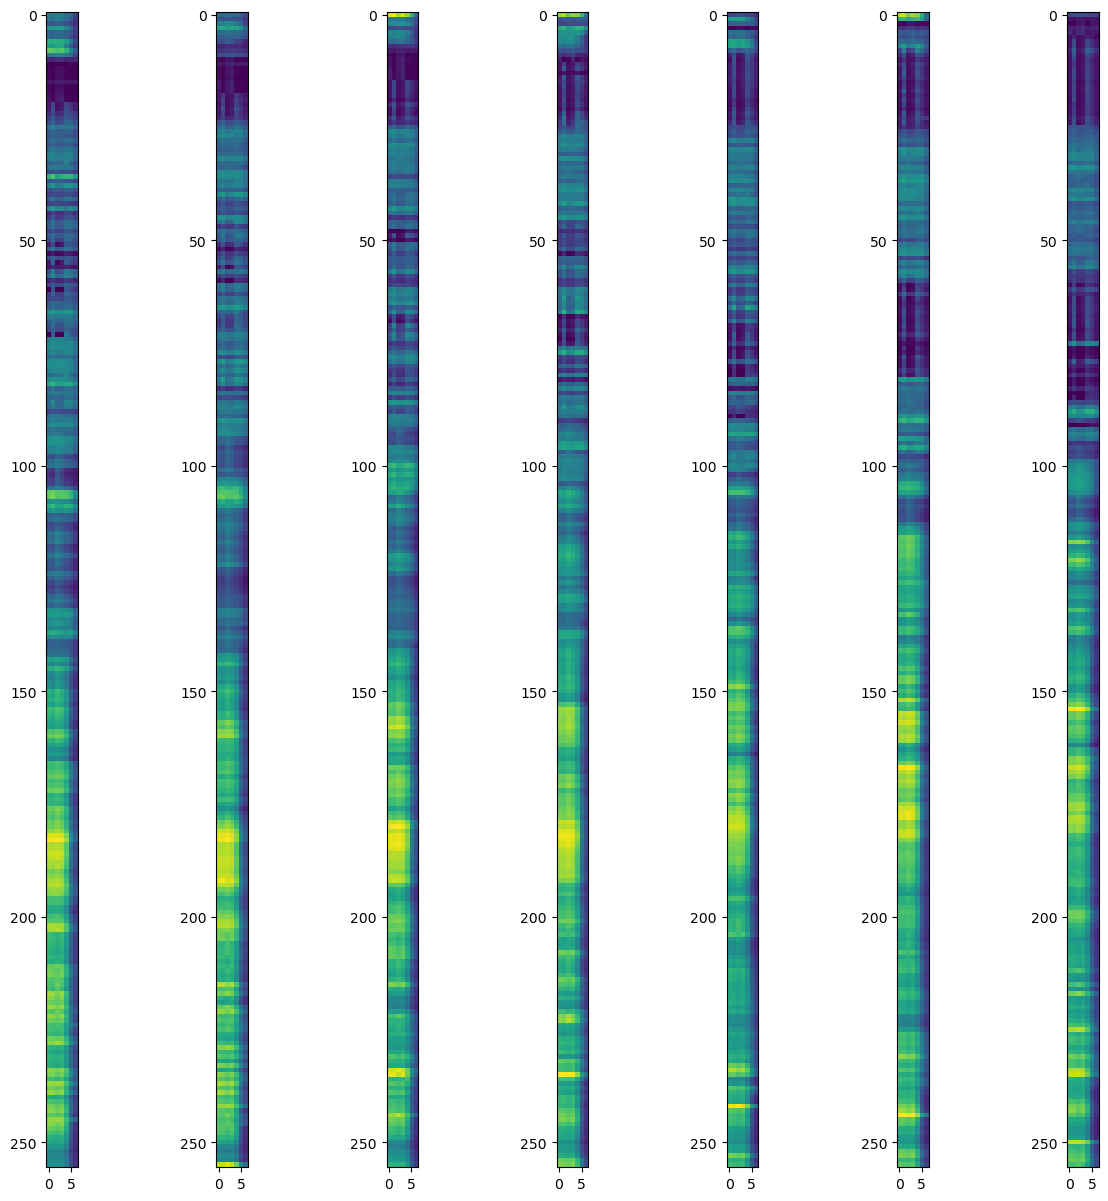

In [8]:
fig, axes = plt.subplots(1,7, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_tiff_merged[i])
    #ax.imshow(resized_img_tiff_merged[i])

In [9]:
feed = np.expand_dims(img_tiff_merged, axis=0)
print(feed,"\n", feed.shape)

[[[[ 4799  4717  5097 ...  4350  3867  2338]
   [ 4437  4295  4867 ...  4026  3284  1825]
   [ 3123  2991  3638 ...  2919  2353  1547]
   ...
   [ 5460  5339  5258 ...  4429  2515  1478]
   [ 5632  5551  5427 ...  4703  2582  1552]
   [ 5849  5796  5679 ...  4918  2813  1664]]

  [[ 4032  3884  4215 ...  3815  3449  2285]
   [ 2774  2690  2965 ...  2718  2746  1969]
   [ 5245  5066  5449 ...  4714  3848  2116]
   ...
   [ 5723  5642  5548 ...  4752  2750  1699]
   [ 5254  5197  5178 ...  4362  2299  1399]
   [10676 10514 11180 ...  9074  5970  4287]]

  [[11378 11670 10303 ...  9904  7588  4369]
   [ 4611  4544  4748 ...  4194  3866  2589]
   [ 5795  5870  5868 ...  5341  4563  2678]
   ...
   [ 6126  5981  5931 ...  5054  2667  1497]
   [ 6649  6476  6453 ...  5436  2921  1760]
   [ 7743  7570  7501 ...  6478  3523  2116]]

  ...

  [[ 1622  2149  1671 ...  2166  1635  1040]
   [ 1552  2220  1570 ...  2307  1870  1415]
   [ 1337  2264  1181 ...  2509  2053  1319]
   ...
   [ 7600  739

In [10]:
res = local_loaded_model.predict(feed)

1/1 [==============================] - 0s 174ms/step


In [11]:
res

array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [1.],
         [1.]]]], dtype=float32)

In [12]:
from matplotlib.colors import ListedColormap

# 1. == cloud
# 0 == else

unet_color_code = {1.0: "white", 0.0: "black"}
unet_cmap = ListedColormap([unet_color_code[i] for i in range(2)])

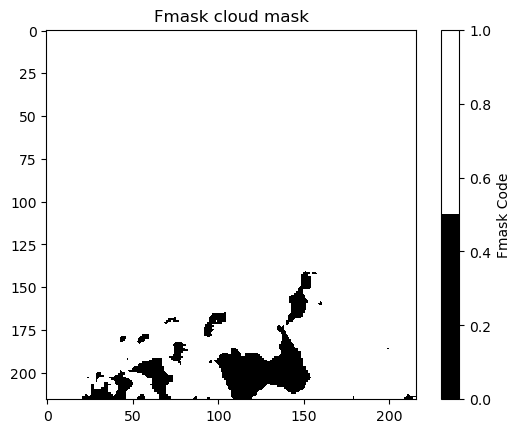

In [14]:
#fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.imshow(res[0], cmap=unet_cmap)
plt.colorbar(label="Unet Code")
plt.title("Unet cloud mask")
plt.show()

In [92]:
def np_3D_array_to_tiff(output_path, np_array, projection, geo_transform, no_data_value=15):
    """
    Note: Filename has to end with .tiff (double f)
    """
    if output_path[-5:] != ".tiff":
        output_path += ".tiff"

    np_array[np.isnan(np_array)] = no_data_value

    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path, np_array.shape[2], np_array.shape[1], np_array.shape[0], gdal.GDT_Float32)
    # where np_array.shape(0) is band amount
    out_raster.SetProjection(projection)
    out_raster.SetGeoTransform(geo_transform)
    
    for i, b in enumerate(np_array):  # np_array has to be sorted (bands) in ascending order
        out_band = out_raster.GetRasterBand(i+1)  # Gdal Rasters start at index 1
        out_band.WriteArray(b)
        # out_band.SetNoDataValue(no_data_value)  # safe?
        out_band.FlushCache()
        out_band = None
    out_raster.FlushCache()
    out_raster = None

In [95]:
np_3D_array_to_tiff(modis_tower_path+day1+"_predicted256_mask", res[0], img_gdal_merged.GetProjection(), img_gdal_merged.GetGeoTransform())

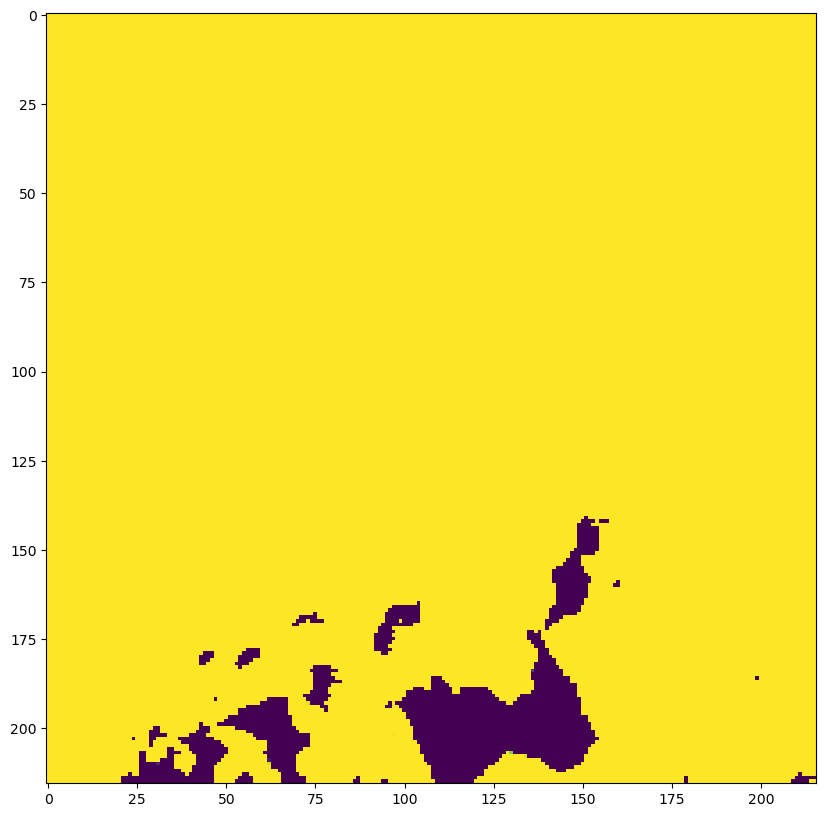

In [21]:
pred_mask = gdal.Open(modis_tower_path+day1+"_predicted256_mask.tiff").ReadAsArray()
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.imshow(pred_mask)

In [181]:
pred_mask

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)